In [74]:
import tensorflow as tf
from os import listdir, path
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model
from nltk.translate.bleu_score import corpus_bleu
from pickle import dump, load
import numpy as np
import string
import re
import matplotlib.pyplot as plt
from PIL import Image

# **Prepare Photo Data**

In [2]:
# extract features from each photo in the directory
def extract_features(directory):
    model = VGG16()
    # restructure the model
    #model.layers.pop()
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    model.summary()

    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        filename = path.join(directory, name)
        image = load_img(filename, target_size = (224,224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image) # prepare img for VGG
        feature = model.predict(image, verbose = 0) # get features
        image_id = name.split('.')[0]
        features[image_id] = feature
        #print(name)
    return features

In [3]:
directory = '/kaggle/input/flickr8k/Images'
features = extract_features(directory)
print(f"Extracted Features: {len(features)}")

# save the file
dump(features, open('features.pkl', 'wb'))

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1721563463.873974     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Extracted Features: 8091


# **Prepare Text Data**

In [4]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [5]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

In [6]:
def clean_descriptions(descriptions):
    # prepare regex for char filtering
    re_punc = re.compile(f"[{re.escape(string.punctuation)}]")
    for _, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [re_punc.sub('', w) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] = ' '.join(desc)

In [7]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [8]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [9]:
filename= '/kaggle/input/flickr8k/captions.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)
clean_descriptions(descriptions)

vocabulary = to_vocabulary(descriptions)
print(f'Vocabulary Size: {len(vocabulary)}')

save_descriptions(descriptions, 'descriptions.txt')

Vocabulary Size: 8680


# **Develop Deep learning Model**

In [10]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [11]:
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

In [12]:
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [13]:
# load training dataset
filename= '/kaggle/input/partitions/Flickr_8k.trainImages.txt'
train = load_set(filename)
print(f'Dataset: {len(train)}')

Dataset: 6000


In [14]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(desc) for desc in descriptions[key]]
    return all_desc

In [15]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [16]:
def calculate_max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [17]:
# create sequences of images, input and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos):
    x1, x2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple x, y pairs
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequences
                in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                # encode output sequences
                out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]

                x1.append(photos[key][0])
                x2.append(in_seq)
                y.append(out_seq)
    return np.array(x1), np.array(x2), np.array(y)

In [18]:
# create data generator to get data in batch (avoids session crash)
def data_generator(descriptions, tokenizer, max_length, batch_size):
    keys = list(descriptions.keys())
    while True:
        #np.random.shuffle(keys)
        for i in range(0, len(keys), batch_size):
            batch_keys = keys[i:i + batch_size]
            batch_descriptions = {k: descriptions[k] for k in batch_keys}
            x1, x2, y = create_sequences(tokenizer, max_length, batch_descriptions)
            yield [x1, x2], y

In [19]:
def batch_data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for key, desc_list in descriptions.items():
            n += 1
            photo = features[key][0]
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                    
                    if n == batch_size:
                        yield (np.array(X1), np.array(X2)), np.array(y)
                        X1, X2, y = [], [], []
                        n = 0

In [61]:
# The captioning Model
def define_model(vocab_size, max_length):

    # feature extractor model
    inputs1 = Input(shape = (4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation = 'relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation = 'relu')(decoder1)
    outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

    model = Model(inputs = [inputs1, inputs2], outputs = outputs)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
    model.summary()

    plot_model(model, to_file = 'model.png', show_shapes = True)
    return model

In [62]:
train_descriptions = load_clean_descriptions('descriptions.txt', train)
train_features = load_photo_features('features.pkl', train)
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer (to use it without loading entire training dataset)
dump(tokenizer, open('tokenizer.pkl','wb'))
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocab_size: {vocab_size}')

max_length = calculate_max_length(train_descriptions)
print(f'Max Sequence length: {max_length}')

# load test set
filename = '/kaggle/input/partitions/Flickr_8k.devImages.txt'
test = load_set(filename)
test_descriptions = load_clean_descriptions('descriptions.txt', test)
test_features = load_photo_features('features.pkl', test)
print('loaded test set')

Vocab_size: 7507
Max Sequence length: 33
loaded test set


In [63]:
# Calculate steps per epoch
epochs = 20
batch_size = 32
steps_per_epoch = len(train_descriptions) // batch_size
validation_steps = len(test_descriptions) // batch_size

train_generator = batch_data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, batch_size)
val_generator = batch_data_generator(test_descriptions, test_features, tokenizer, max_length, vocab_size, batch_size)

# Define and compile your model
model = define_model(vocab_size, max_length)

# Define callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

callbacks = [checkpoint]

# Train the model
history = model.fit(
    train_generator,
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_generator,
    validation_steps = validation_steps,
    callbacks = callbacks,
    verbose = 1
)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 33, 256)   │  1,921,792 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4096)      │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 33, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_15        │ (None, 33)        │          0 │ input_layer_12[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 7507)      │  1,929,299 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,491,027 (20.95 MB)

 Trainable params: 5,491,027 (20.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 5.9278
Epoch 1: val_loss improved from inf to 4.49141, saving model to best_model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 52s 269ms/step - loss: 5.9246 - val_loss: 4.4914
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 4.2845
Epoch 2: val_loss improved from 4.49141 to 4.06493, saving model to best_model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 264ms/step - loss: 4.2838 - val_loss: 4.0649
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 3.7756
Epoch 3: val_loss improved from 4.06493 to 3.94804, saving model to best_model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 268ms/step - loss: 3.7753 - val_loss: 3.9480
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 3.4780
Epoch 4: val_loss improved from 3.94804 to 3.93344, saving model to best_model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 275ms/step - loss: 3.4778 - val_loss: 3.9334
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 3.2587
Epoch 5

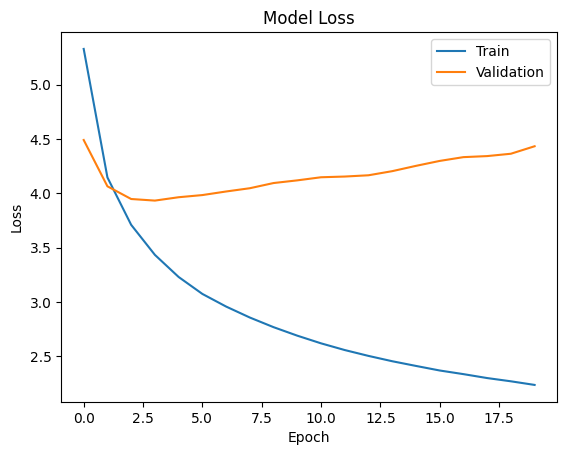

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# **Evaluate Model**

In [66]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [67]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        # integer encode input
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')
        
        yhat = model.predict([photo, sequence], verbose = 0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        
        if word is None:
            break
        
        in_text += ' ' + word
        if word == 'endseq':
            break
            
    print(in_text) #----------------------------predicted-------------------------------
    return in_text

In [68]:
# remove start/end sequence tokens from summary
def cleanup_summary(summary):
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
    index = summary.find(' endseq')
    if index > -1:
        summary = summary[: index]
    return summary

In [69]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        yhat = cleanup_summary(yhat)
        references = [cleanup_summary(d).split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    # calculate BLUE score
    print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
    print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')
    print(f'BLEU-3: {corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))}')
    print(f'BLEU-4: {corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))}')

In [70]:
# load test set
filename = '/kaggle/input/partitions/Flickr_8k.testImages.txt'
test = load_set(filename)
print(f'Dataset: {len(test)}')

# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)

# photo features
test_features = load_photo_features('features.pkl', test)

# load_the model
filename = 'best_model.keras'
model = load_model(filename)

# evaluate the model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 1000
startseq boy in blue shirt and blue shirt and blue shirt and blue shirt and blue shirt and blue shirt and blue shirt and blue shirt and blue shirt and blue shirt and blue
startseq boy in blue shorts is jumping into the water endseq
startseq boy in blue shirt is jumping on trampoline endseq
startseq brown dog is running on the water endseq
startseq boy in blue shirt is playing on the water endseq
startseq black dog is running through the grass endseq
startseq brown dog is playing in the grass endseq
startseq boy is holding his arm endseq
startseq dogs are playing in the water endseq
startseq little boy is playing on bed endseq
startseq man in red shirt is standing on the beach endseq
startseq man in red shirt and black shirt and black shirt and black shirt and black shirt and black shirt is riding the water endseq
startseq man is running through the snow endseq
startseq woman in white shirt and white shirt and white shirt and white shirt and white shirt and white shirt and

# **Generate New Captions**

In [71]:
def extract_features_from_photo(filename):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

In [72]:
tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = max_length # pre-define the max sequence length (from training)

startseq brown dog is running on the sand endseq
brown dog is running on the sand


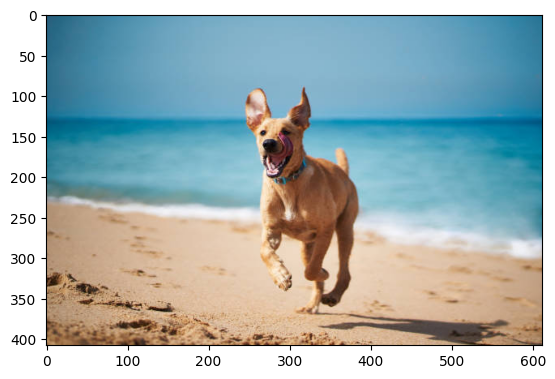

In [78]:
model = load_model('best_model.keras')

path = '/kaggle/input/example/example1.jpg'
photo = extract_features_from_photo(path)

description = generate_desc(model, tokenizer, photo, max_length)
description = cleanup_summary(description)
image = Image.open(path)
plt.imshow(image)
print(description)